# TASK
Необходимо разработать алгоритм, позволяющий определить:
* совпадение траектории 3 и траектории 1;
* незначительное отличие траектории 2 от траектории 1;
* существенное отличие траектории 4 от траекторий 1, 2 и 3.

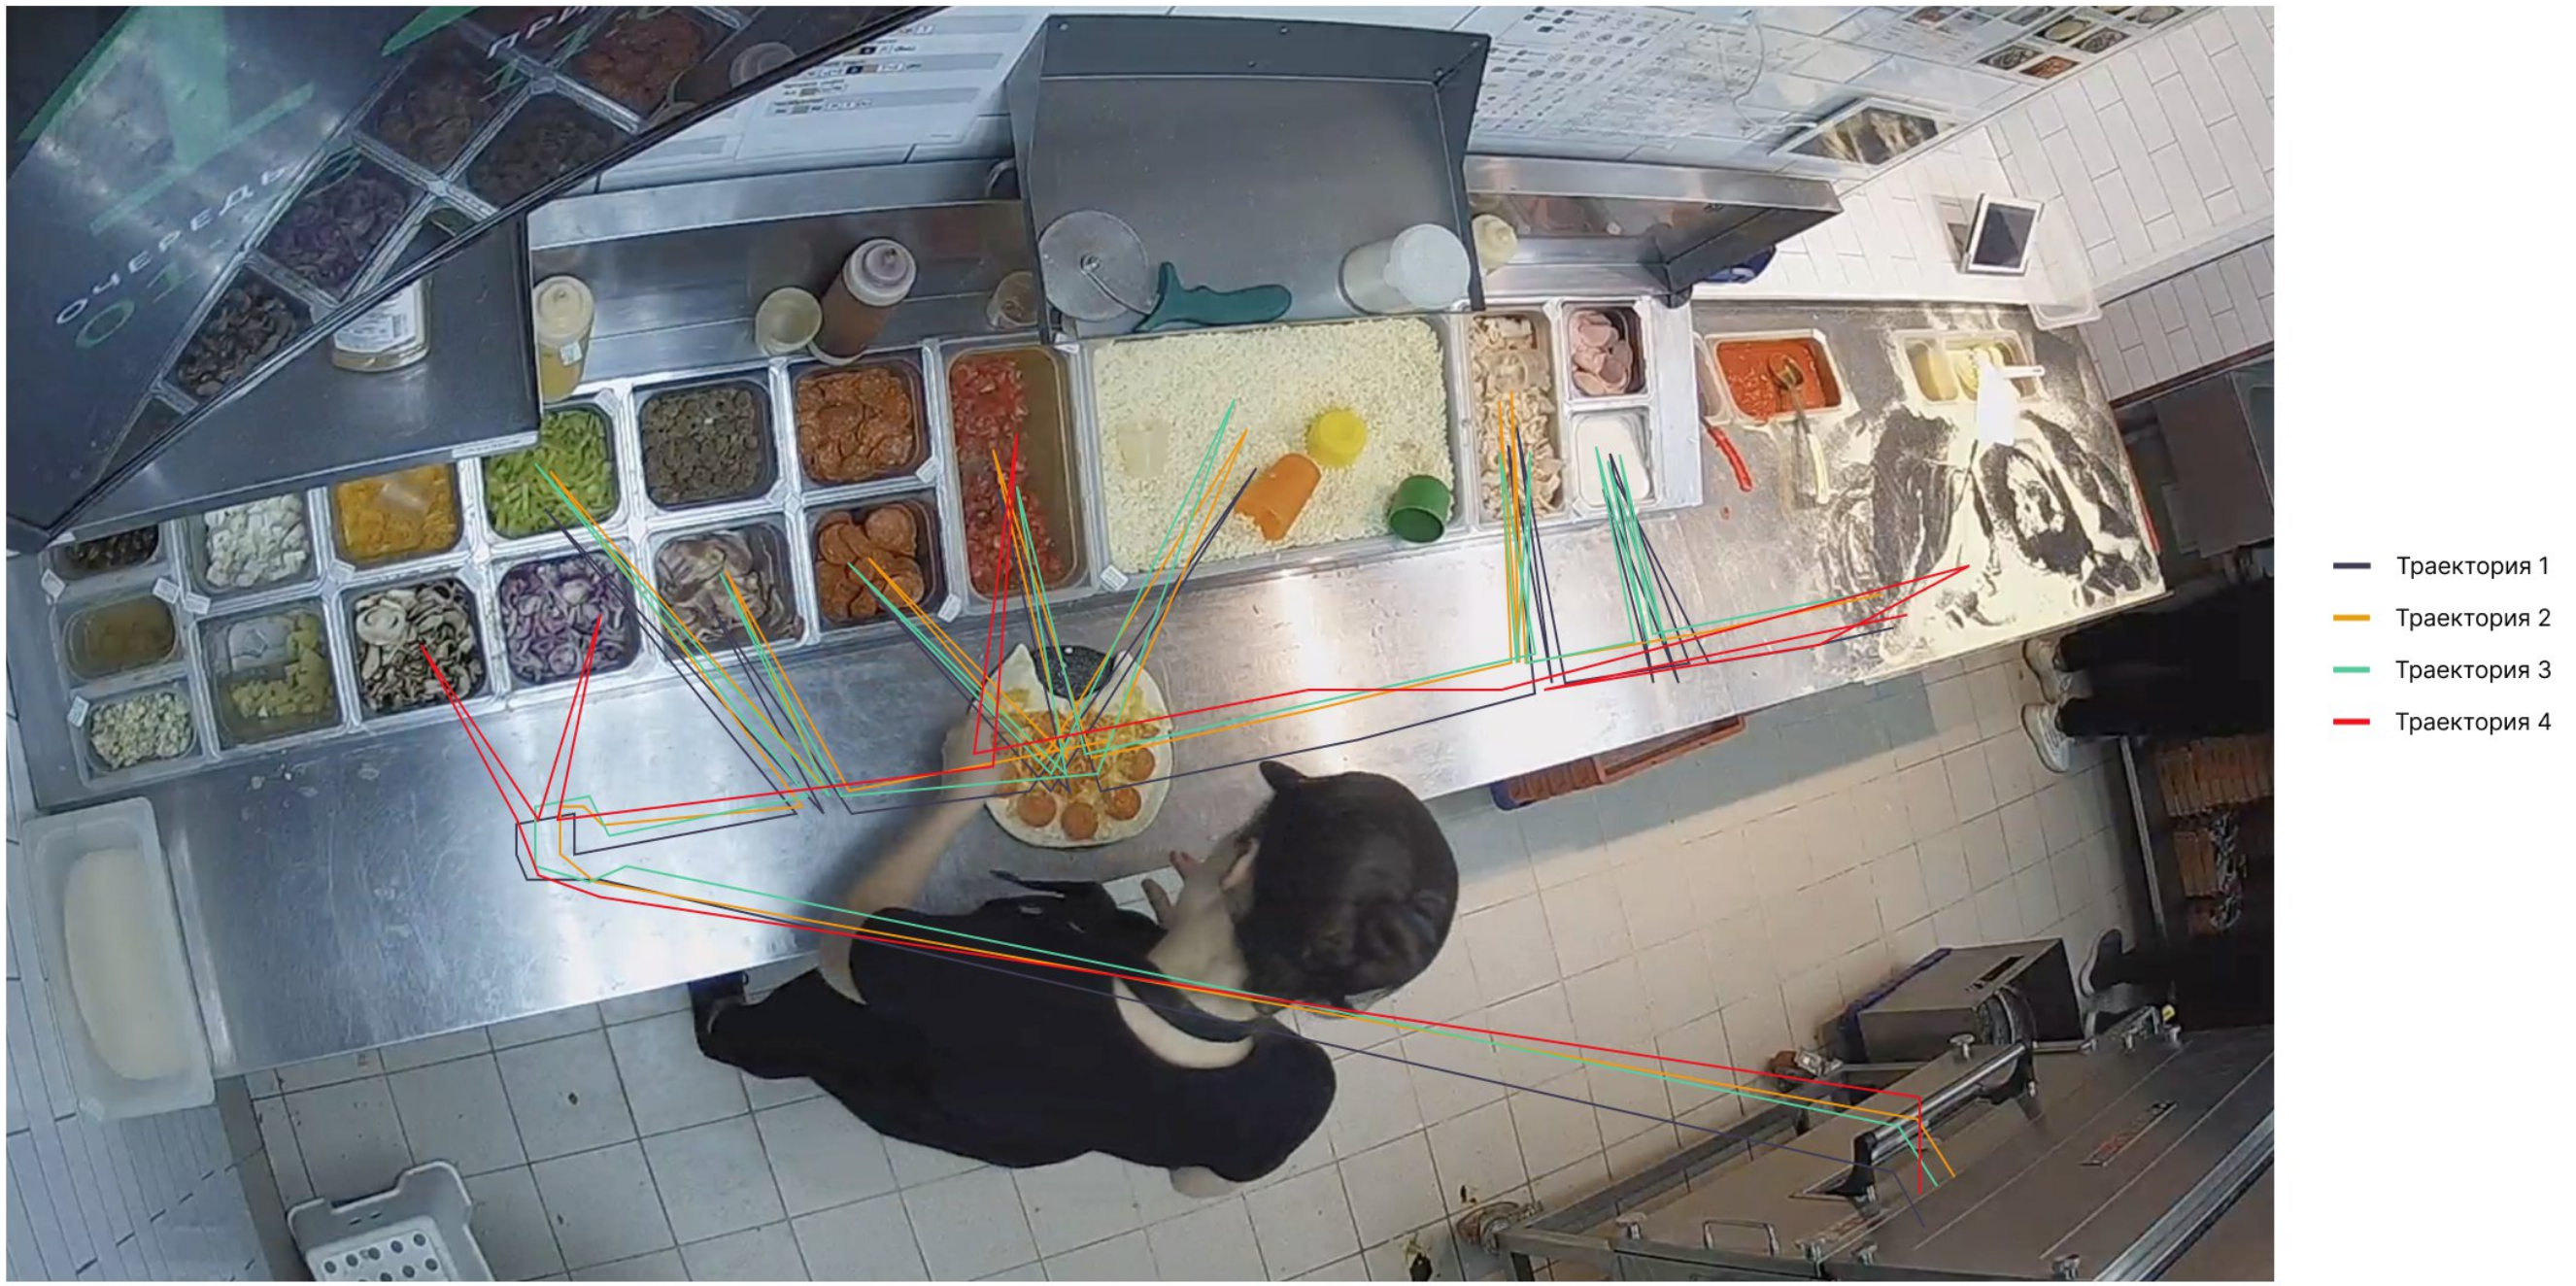

### **Для решения задачи было опробовано два метода:**
* Расстояние Хаусдорфа (Hausdorff distance) - **показал лучший результат**;
* Поиск максимально длинной последовательности (longest common subsequence).

<br>

### **Пайплайн состоял из следующих шагов:**
1. Пикирование траекторий точек с определенным шагом;
2. Оценка расстояния Хаусдорфа / Поиск максимально длинной последовательности;
3. Кластеризация данных и формирование окаймляющей рамки.

<br>

### **Результат:**  
Основной вопрос в численном понятии терминов "совпадает", "незначтельно отличается" и "существенно отличается", в связи с чем, границы выставлялись субъективно. Наилучший и самый быстрый результат показал метод **расстояния Хаусдорфа**. Однако этот метод не очень хорошо работает в областях повторения траекторий (траектория 4). В местах повторения траектории метод последовательностей работает лучше (если повторение траектории все таки считать отклонением). Так или иначе, оба метода показали очень близкий результат.

---
# 0. Libraries and data loading

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import directed_hausdorff
from IPython.display import clear_output
from time import sleep
from sklearn.cluster import MeanShift, DBSCAN, OPTICS
from matplotlib.patches import Rectangle

import math
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('traks.csv', sep=';')

In [222]:
df.head()

track      time     x    y
0      1  10:32:13  1598  526
1      1  10:32:14  1524  544
2      1  10:32:15  1441  557
3      1  10:32:16  1357  392
4      1  10:32:17  1395  573

In [4]:
df.describe()

track            x            y
count  114.000000   114.000000   114.000000
mean     2.315789   994.385965   595.719298
std      1.083389   408.667347   157.821761
min      1.000000   351.000000   325.000000
25%      1.000000   605.250000   495.750000
50%      2.000000   921.500000   579.000000
75%      3.000000  1355.000000   682.500000
max      4.000000  1662.000000  1034.000000

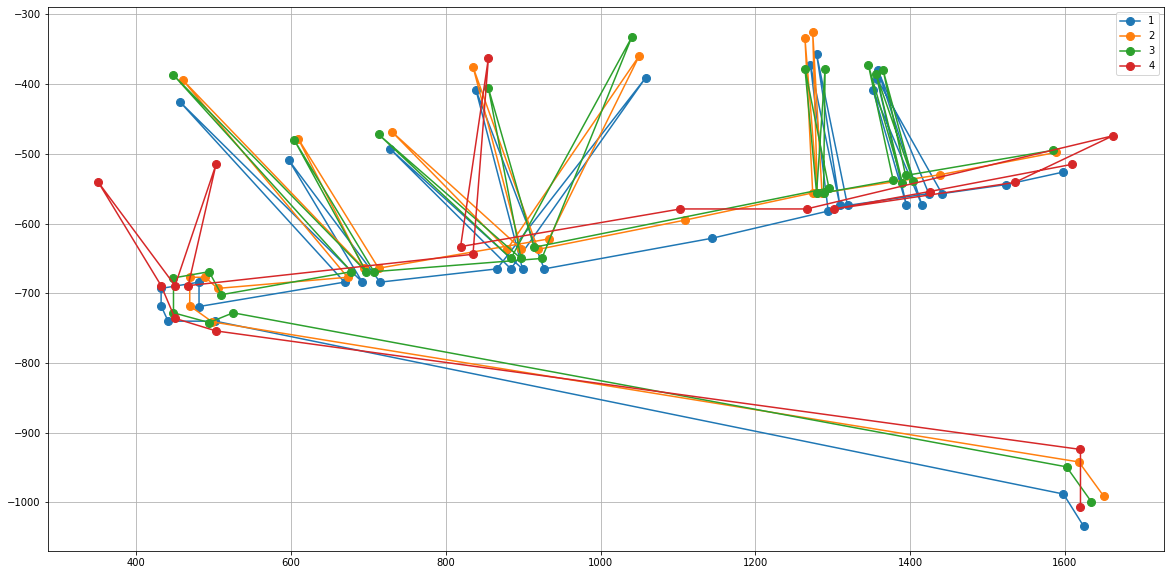

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(df.loc[df['track']==1, ['x', 'y']].values[:, 0], -df.loc[df['track']==1, ['x', 'y']].values[:, 1], label=1, marker='o', markersize=8)
plt.plot(df.loc[df['track']==2, ['x', 'y']].values[:, 0], -df.loc[df['track']==2, ['x', 'y']].values[:, 1], label=2, marker='o', markersize=8)
plt.plot(df.loc[df['track']==3, ['x', 'y']].values[:, 0], -df.loc[df['track']==3, ['x', 'y']].values[:, 1], label=3, marker='o', markersize=8)
plt.plot(df.loc[df['track']==4, ['x', 'y']].values[:, 0], -df.loc[df['track']==4, ['x', 'y']].values[:, 1], label=4, marker='o', markersize=8)
plt.grid()
plt.legend()
plt.show()

---
# 1. Hausdorff Distance

##### 1.1 Additional point for tracks

In [342]:
def dataframe_expand(df: pd.DataFrame,
                     max_dist: int=30) -> pd.DataFrame:
    """
    Method create addition points on a track if a distance between neighbour points more than max_dist
    
    :param df:       input dataframe with
    :param max_dist: maximum distance between neighbour points
    
    :return:         data frame with added points on tracks
    """
    indexes = [0]
    while len(indexes):
        indexes = df.loc[np.sqrt(df['x'].diff()**2 + df['y'].diff()**2) > max_dist].index
        df = pd.concat([df, pd.DataFrame(index=indexes-0.5)])
        df = df.sort_index().reset_index(drop=True)
        df.interpolate(method='linear', inplace=True)
        
    return df

In [343]:
df_1 = dataframe_expand(df.loc[df['track']==1, ['x', 'y']])
df_2 = dataframe_expand(df.loc[df['track']==2, ['x', 'y']])
df_3 = dataframe_expand(df.loc[df['track']==3, ['x', 'y']])
df_4 = dataframe_expand(df.loc[df['track']==4, ['x', 'y']])

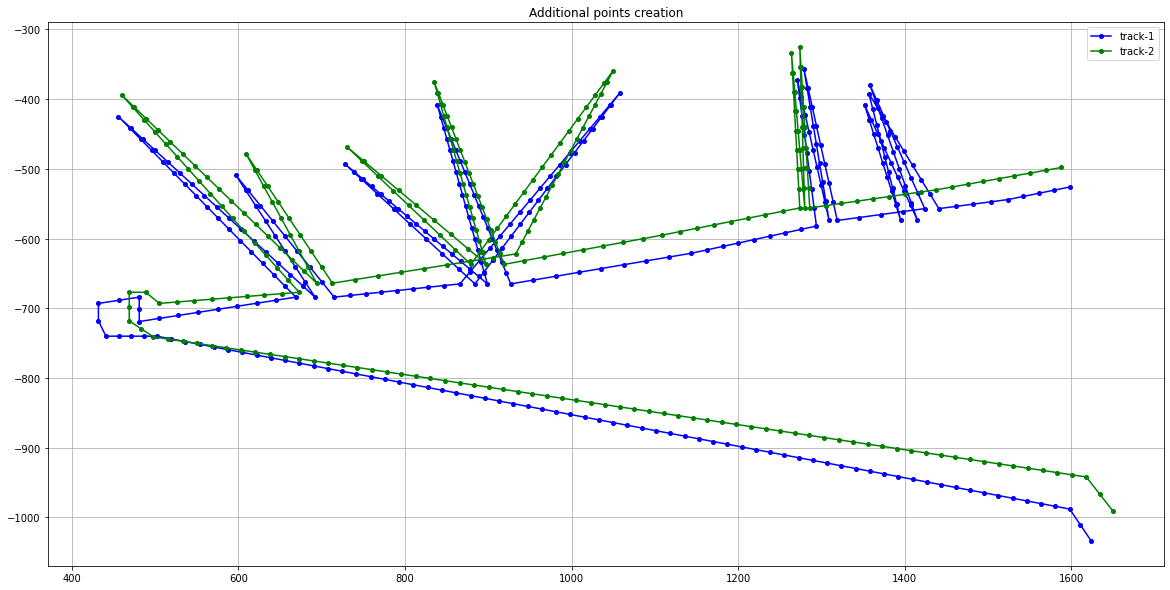

In [345]:
plt.figure(figsize=(20, 10))
plt.plot(df_1.values[:, 0], -df_1.values[:, 1], label='track-1', marker='o', markersize=4, color='blue')
plt.plot(df_2.values[:, 0], -df_2.values[:, 1], label='track-2', marker='o', markersize=4, color='green')
plt.grid()
plt.legend()
plt.title('Additional points creation')
plt.show()

##### 1.2 Calculation of Hausdorff coefficient

In [346]:
def hausdorff_coeff(df_main: pd.DataFrame,
                    df_add: pd.DataFrame) -> list:
    """
    Method estimates Hausdorff distance between each point of df_main and sequence of df_add
    
    :param df_main: track of which points Hausdorff distance will be calculated
    :param df_add:  second track for Hausdorff distance estimation
    
    :return:        list of touples with Hausdorff coefficient and indexes of main and addition dataframes
    """
    hausdorff_coeff = []
    for i in range(len(df_main)):
        slice_df = df_main[i:i+1]
        hausdorff_coeff.append((directed_hausdorff(slice_df.values, df_add.values)[0], i, directed_hausdorff(slice_df.values, df_add.values)[2]))
        
    return hausdorff_coeff

In [321]:
hausdorff_coeff_1 = hausdorff_coeff(df_1, df_2)
hausdorff_coeff_2 = hausdorff_coeff(df_2, df_1)

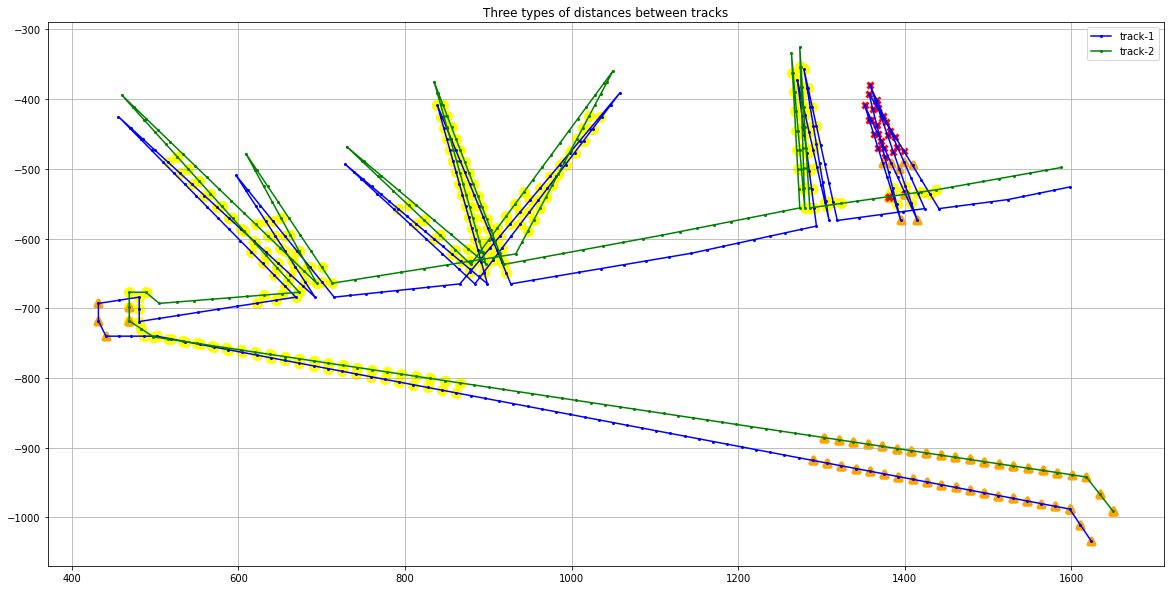

In [352]:
plt.figure(figsize=(20, 10))
plt.plot(df_1.values[:, 0], -df_1.values[:, 1], label='track-1', marker='o', markersize=2, color='blue')
plt.plot(df_2.values[:, 0], -df_2.values[:, 1], label='track-2', marker='o', markersize=2, color='green')

for i in range(len(df_2)):
    if hausdorff_coeff_2[i][0] < 15.:
        plt.scatter(df_2.values[i, 0], -df_2.values[i, 1], marker='o', linewidths=5, color='red')
        plt.scatter(df_1.values[hausdorff_coeff_2[i][2], 0], -df_1.values[hausdorff_coeff_2[i][2], 1], marker='o', linewidths=5, color='red',)
    elif hausdorff_coeff_2[i][0] > 35. and hausdorff_coeff_2[i][0] < 50.5:
        plt.scatter(df_2.values[i, 0], -df_2.values[i, 1], marker='^', linewidths=4, color='brown')
        plt.scatter(df_1.values[hausdorff_coeff_2[i][2], 0], -df_1.values[hausdorff_coeff_2[i][2], 1], marker='^', linewidths=4, color='brown')
    elif hausdorff_coeff_2[i][0] > 50.5:
        plt.scatter(df_2.values[i, 0], -df_2.values[i, 1], marker='x', linewidths=3, color='orange')
        plt.scatter(df_1.values[hausdorff_coeff_2[i][2], 0], -df_1.values[hausdorff_coeff_2[i][2], 1], marker='x', linewidths=3, color='orange')

for i in range(len(df_1)):
    if hausdorff_coeff_1[i][0] < 15.:
        plt.scatter(df_1.values[i, 0], -df_1.values[i, 1], marker='o', linewidths=5, color='red')
        plt.scatter(df_2.values[hausdorff_coeff_1[i][2], 0], -df_2.values[hausdorff_coeff_1[i][2], 1], marker='o', linewidths=5, color='red')
    elif hausdorff_coeff_1[i][0] > 35. and hausdorff_coeff_1[i][0] < 50.5:
        plt.scatter(df_1.values[i, 0], -df_1.values[i, 1], marker='^', linewidths=4, color='brown')
        plt.scatter(df_2.values[hausdorff_coeff_1[i][2], 0], -df_2.values[hausdorff_coeff_1[i][2], 1], marker='^', linewidths=4, color='brown')
    elif hausdorff_coeff_1[i][0] > 50.5:
        plt.scatter(df_1.values[i, 0], -df_1.values[i, 1], marker='x', linewidths=3, color='orange')
        plt.scatter(df_2.values[hausdorff_coeff_1[i][2], 0], -df_2.values[hausdorff_coeff_1[i][2], 1], marker='x', linewidths=3, color='orange')      
        
plt.grid()
plt.legend()
plt.title('Three types of distances between tracks')
plt.show()

##### 1.3 Clustering points and box drawing

In [347]:
clusters = DBSCAN(eps=50, min_samples=5)
# Medium difference
X = np.concatenate(
    (df_1.values[np.array(hausdorff_coeff_1)[np.where((np.array(hausdorff_coeff_1)[:,0]>35) & (np.array(hausdorff_coeff_1)[:,0]<50.5)), 1].astype('int16')],
     df_2.values[np.array(hausdorff_coeff_1)[np.where((np.array(hausdorff_coeff_1)[:,0]>35) & (np.array(hausdorff_coeff_1)[:,0]<50.5)), 2].astype('int16')],
     df_2.values[np.array(hausdorff_coeff_2)[np.where((np.array(hausdorff_coeff_2)[:,0]>35) & (np.array(hausdorff_coeff_2)[:,0]<50.5)), 1].astype('int16')],
     df_1.values[np.array(hausdorff_coeff_2)[np.where((np.array(hausdorff_coeff_2)[:,0]>35) & (np.array(hausdorff_coeff_2)[:,0]<50.5)), 2].astype('int16')],
    ), axis=1)[0]
X = np.unique(X, axis=0)
predict = clusters.fit_predict(X)
data = np.append(X, predict.reshape(-1, 1), axis=1).astype('int16')

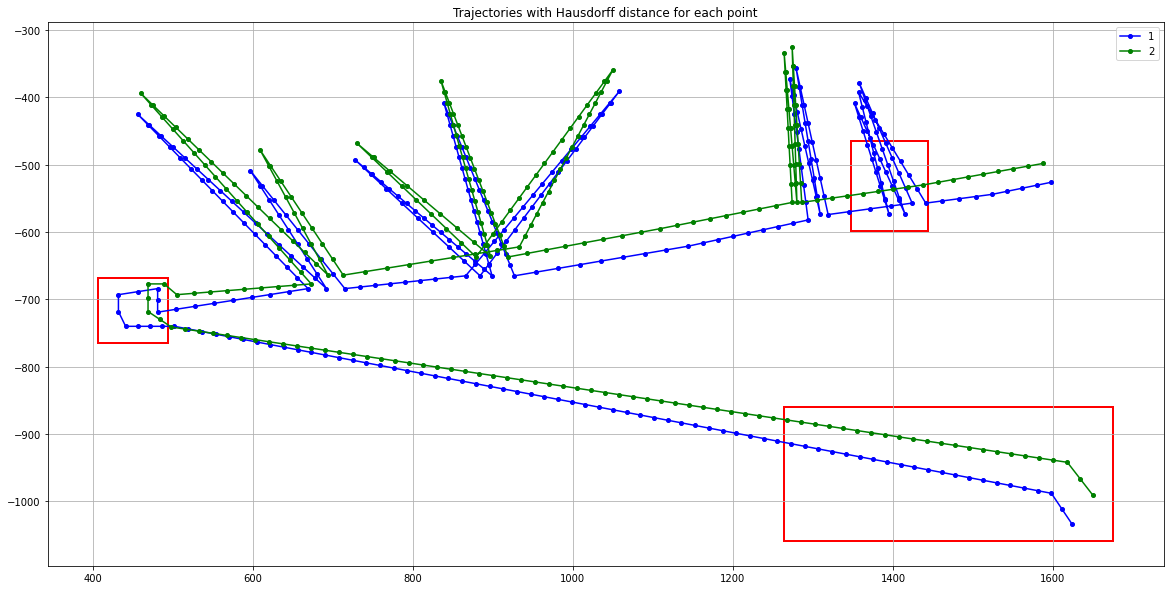

In [348]:
padding = 25

plt.figure(figsize=(20, 10))
plt.plot(df_1.values[:, 0], -df_1.values[:, 1], label='track-1', marker='o', markersize=4, color='blue')
plt.plot(df_2.values[:, 0], -df_2.values[:, 1], label='track-2', marker='o', markersize=4, color='green')

for class_item in np.unique(data[:,2]):
    if class_item==-1:
        continue
    y_min, x_min = min(data[np.where(data[:,2]==class_item)][:,1]), min(data[np.where(data[:,2]==class_item)][:,0])
    y_max, x_max = max(data[np.where(data[:,2]==class_item)][:,1]), max(data[np.where(data[:,2]==class_item)][:,0])
    plt.gca().add_patch(Rectangle((x_min-padding, -(y_min-padding)), x_max-x_min+2*padding, -(y_max-y_min+2*padding), linewidth=2, edgecolor='red', facecolor='none'))

plt.grid()
plt.legend()
plt.title('Medium difference between tracks')
plt.show()

## Final code for task solving by Hausdorff distance

In [382]:
def dataframe_expand(df: pd.DataFrame,
                     max_dist: int=30) -> pd.DataFrame:
    """
    Method create addition points on a track if a distance between neighbour points more than max_dist
    
    :param df:       input dataframe with
    :param max_dist: maximum distance between neighbour points
    
    :return:         data frame with added points on tracks
    """
    indexes = [0]
    while len(indexes):
        indexes = df.loc[np.sqrt(df['x'].diff()**2 + df['y'].diff()**2) > max_dist].index
        df = pd.concat([df, pd.DataFrame(index=indexes-0.5)])
        df = df.sort_index().reset_index(drop=True)
        df.interpolate(method='linear', inplace=True)
        
    return df

In [598]:
df_1 = dataframe_expand(df.loc[df['track']==1, ['x', 'y']])
df_2 = dataframe_expand(df.loc[df['track']==2, ['x', 'y']])
df_3 = dataframe_expand(df.loc[df['track']==3, ['x', 'y']])
df_4 = dataframe_expand(df.loc[df['track']==4, ['x', 'y']])

In [676]:
def quality_distance_estimation(df_1: pd.DataFrame, 
                                df_2: pd.DataFrame,
                                show_far=True,
                                show_medium=True,
                                show_close=True,
                                draw_points=False,
                                title='Graph',
                               ) -> None:
    
    def hausdorff_coeff(df_main: pd.DataFrame,
                    df_add: pd.DataFrame) -> list:
        """
        Method estimates Hausdorff distance between each point of df_main and sequence of df_add

        :param df_main: track of which points Hausdorff distance will be calculated
        :param df_add:  second track for Hausdorff distance estimation

        :return:        list of touples with Hausdorff coefficient and indexes of main and addition dataframes
        """
        hausdorff_coeff = []
        for i in range(len(df_main)):
            slice_df = df_main[i:i+1]
            hausdorff_coeff.append((directed_hausdorff(slice_df.values, df_add.values)[0], i, directed_hausdorff(slice_df.values, df_add.values)[2]))

        return hausdorff_coeff
    
    hausdorff_coeff_1 = hausdorff_coeff(df_1, df_2)
    hausdorff_coeff_2 = hausdorff_coeff(df_2, df_1)
    
    clusters = DBSCAN(eps=45, min_samples=2)
    # High difference
    X_far = np.unique(np.concatenate(
        (df_1.values[np.array(hausdorff_coeff_1)[np.where(np.array(hausdorff_coeff_1)[:,0]>50.5), 1].astype('int16')],
         df_2.values[np.array(hausdorff_coeff_2)[np.where(np.array(hausdorff_coeff_2)[:,0]>50.5), 1].astype('int16')],
        ), axis=1)[0], axis=0)
    # Medium difference
    X_medium = np.unique(np.concatenate(
        (df_1.values[np.array(hausdorff_coeff_1)[np.where((np.array(hausdorff_coeff_1)[:,0]>35) & (np.array(hausdorff_coeff_1)[:,0]<50.5)), 1].astype('int16')],
         df_2.values[np.array(hausdorff_coeff_2)[np.where((np.array(hausdorff_coeff_2)[:,0]>35) & (np.array(hausdorff_coeff_2)[:,0]<50.5)), 1].astype('int16')],
        ), axis=1)[0], axis=0)
    # Almost equal
    X_close = np.unique(np.concatenate(
        (df_1.values[np.array(hausdorff_coeff_1)[np.where(np.array(hausdorff_coeff_1)[:,0]<15), 1].astype('int16')],
         df_2.values[np.array(hausdorff_coeff_2)[np.where(np.array(hausdorff_coeff_2)[:,0]<15), 1].astype('int16')],
        ), axis=1)[0], axis=0)

    predict_far = clusters.fit_predict(X_far)
    predict_medium = clusters.fit_predict(X_medium)
    predict_close = clusters.fit_predict(X_close)
    
    combined_data_far = np.append(X_far, predict_far.reshape(-1, 1), axis=1).astype('int16')
    combined_data_medium = np.append(X_medium, predict_medium.reshape(-1, 1), axis=1).astype('int16')
    combined_data_close = np.append(X_close, predict_close.reshape(-1, 1), axis=1).astype('int16')

    def _draw_rectangle(data, col, padding=15):
        for class_item in np.unique(data[:,2]):
            # don't show noise class
            if class_item==-1:
                continue
            y_min, x_min = min(data[np.where(data[:,2]==class_item)][:,1]), min(data[np.where(data[:,2]==class_item)][:,0])
            y_max, x_max = max(data[np.where(data[:,2]==class_item)][:,1]), max(data[np.where(data[:,2]==class_item)][:,0])
            plt.gca().add_patch(Rectangle((x_min-padding, -(y_min-padding)), x_max-x_min+2*padding, -(y_max-y_min+2*padding), linewidth=2, edgecolor=col, facecolor='none'))

    
    plt.figure(figsize=(20, 10))
    plt.plot(df_1.values[:, 0], -df_1.values[:, 1], label='first track', marker='o', markersize=0, color='blue')
    plt.plot(df_2.values[:, 0], -df_2.values[:, 1], label='second track', marker='o', markersize=0, color='green')
           
    if show_far:
        title = 'Far distance between tracks'
        _draw_rectangle(combined_data_far, col='red')
        if draw_points:
            for i in range(len(df_2)):
                if hausdorff_coeff_2[i][0] > 50.5:
                    plt.scatter(df_2.values[i, 0], -df_2.values[i, 1], marker='x', linewidths=3, color='red')

            for i in range(len(df_1)):
                if hausdorff_coeff_1[i][0] > 50.5:
                    plt.scatter(df_1.values[i, 0], -df_1.values[i, 1], marker='x', linewidths=3, color='red')
    
    if show_medium:
        title = 'Medium distance between tracks'
        _draw_rectangle(combined_data_medium, col='brown')
        if draw_points:
            for i in range(len(df_2)):
                if hausdorff_coeff_2[i][0] > 35. and hausdorff_coeff_2[i][0] < 50.5:
                    plt.scatter(df_2.values[i, 0], -df_2.values[i, 1], marker='^', linewidths=3, color='brown')

            for i in range(len(df_1)):
                if hausdorff_coeff_1[i][0] > 35. and hausdorff_coeff_1[i][0] < 50.5:
                    plt.scatter(df_1.values[i, 0], -df_1.values[i, 1], marker='^', linewidths=3, color='brown')
                    
    if show_close:
        title = 'Close distance between tracks'
        _draw_rectangle(combined_data_close, col='orange')
        if draw_points:
            for i in range(len(df_2)):
                if hausdorff_coeff_2[i][0] < 15.:
                    plt.scatter(df_2.values[i, 0], -df_2.values[i, 1], marker='o', linewidths=3, color='orange')

            for i in range(len(df_1)):
                if hausdorff_coeff_1[i][0] < 15.:
                    plt.scatter(df_1.values[i, 0], -df_1.values[i, 1], marker='o', linewidths=3, color='orange')   
    
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

### The close regions of 1-st and 3-rd tracks

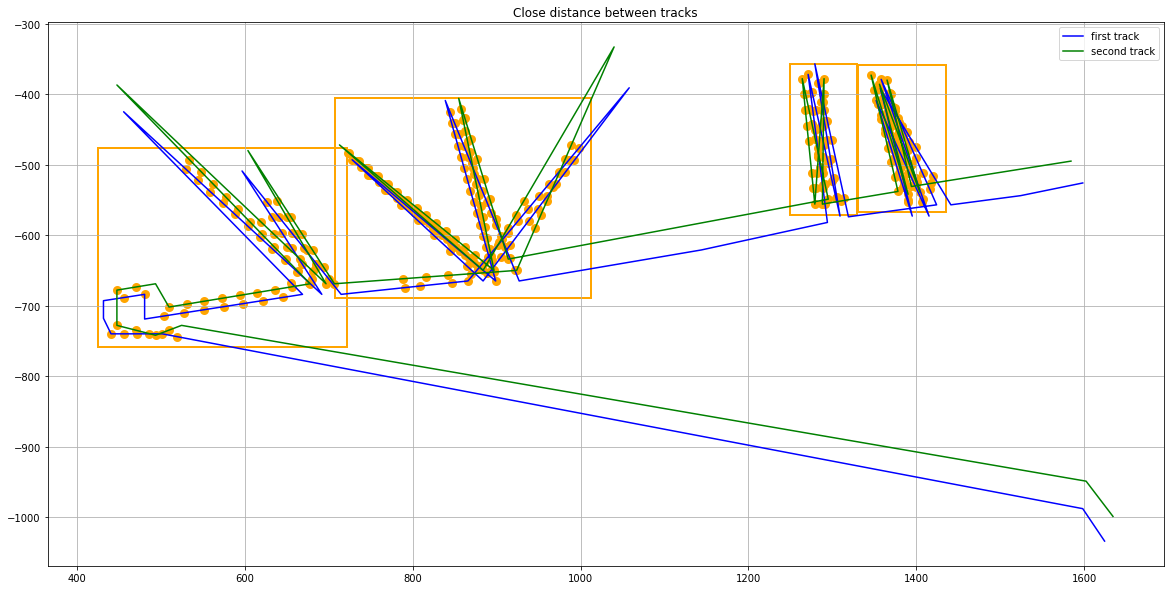

In [677]:
quality_distance_estimation(df_1, 
                            df_3, 
                            show_far=False,
                            show_medium=False,
                            show_close=True, 
                            draw_points=True)

### The small deviation regions between 1-st and 2-rd tracks

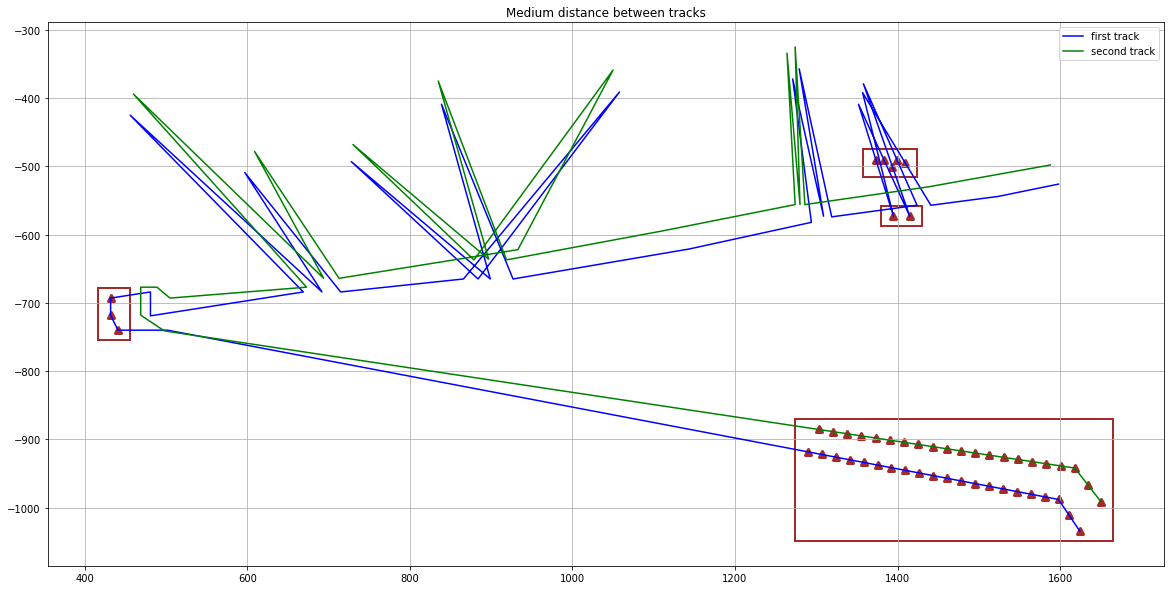

In [678]:
quality_distance_estimation(df_1, 
                            df_2, 
                            show_far=False,
                            show_medium=True,
                            show_close=False, 
                            draw_points=True)

### The high deviation regions between 1-st and 4-rd tracks

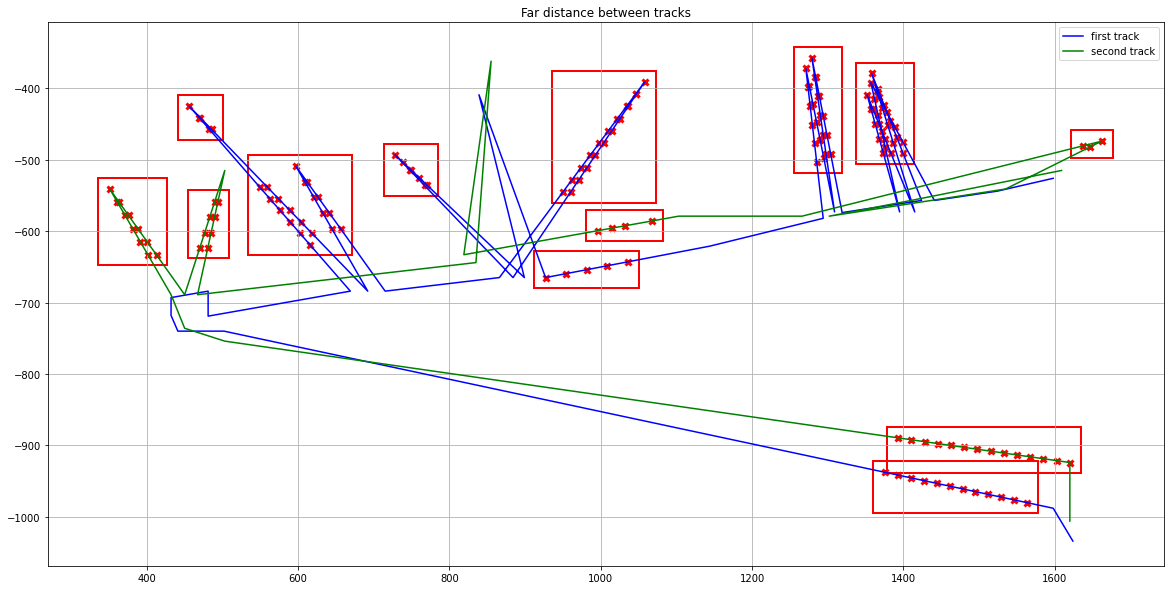

In [679]:
quality_distance_estimation(df_1, 
                            df_4, 
                            show_far=True,
                            show_medium=False,
                            show_close=False, 
                            draw_points=True)

### The small deviation regions of 2-st and 4-rd tracks

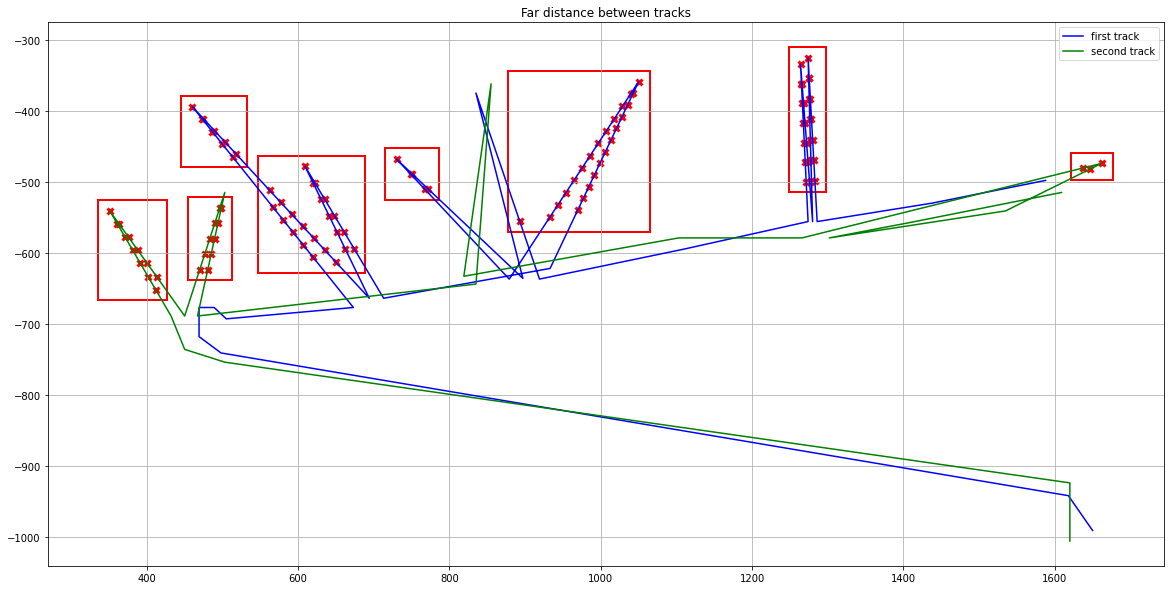

In [680]:
quality_distance_estimation(df_2, 
                            df_4, 
                            show_far=True,
                            show_medium=False,
                            show_close=False, 
                            draw_points=True)

### The small deviation regions of 3-st and 4-rd tracks

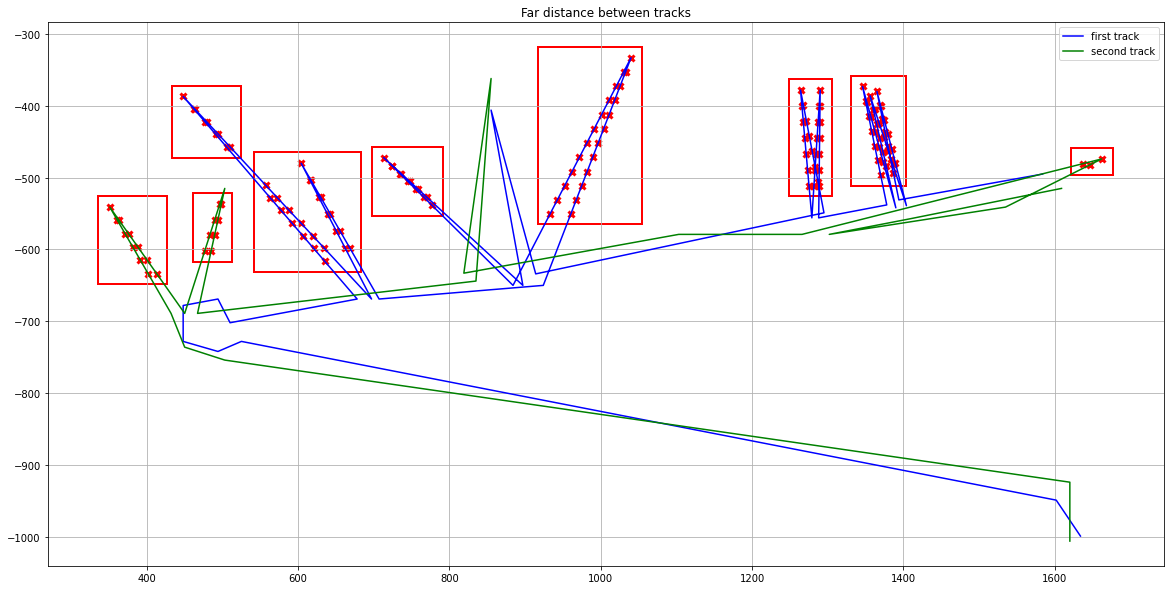

In [681]:
quality_distance_estimation(df_3, 
                            df_4, 
                            show_far=True,
                            show_medium=False,
                            show_close=False, 
                            draw_points=True)

---
# 2. Longest Common Subsequence

In [196]:
df_1 = dataframe_expand(df.loc[df['track']==1, ['x', 'y']], max_dist=50)
df_2 = dataframe_expand(df.loc[df['track']==2, ['x', 'y']], max_dist=50)
df_3 = dataframe_expand(df.loc[df['track']==3, ['x', 'y']], max_dist=50)
df_4 = dataframe_expand(df.loc[df['track']==4, ['x', 'y']], max_dist=50)

In [333]:
def lcss(data_1, data_2, distance_1=40, distance_2=70):
    
    df_1 = data_1.copy()
    df_2 = data_2.copy()
    df_1.loc[len(df_1)] = [0, 0]
    df_2.loc[len(df_2)] = [0, 0]

    lcss_matrix_close = [[pd.DataFrame() for x in range(len(df_2)-1)] for x in range(len(df_1)-1)]
    lcss_matrix_medium = [[pd.DataFrame() for x in range(len(df_2)-1)] for x in range(len(df_1)-1)]
    lcss_matrix_far = [[pd.DataFrame() for x in range(len(df_2)-1)] for x in range(len(df_1)-1)]
    
    def euclide_distance(x1, x2, y1, y2):
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    for i in range(len(df_1)-1):
        for j in range(len(df_2)-1):
            if (euclide_distance(df_1.loc[i, 'x'], df_2.loc[j, 'x'], df_1.loc[i, 'y'], df_2.loc[j, 'y']) < distance_1) & \
                (euclide_distance(df_1.loc[i+1, 'x'], df_2.loc[j+1, 'x'], df_1.loc[i+1, 'y'], df_2.loc[j+1, 'y']) < distance_1):
                if i == 0 or j == 0:
                    lcss_matrix_close[i][j] = df_1.loc[[i]]
                else:
                    lcss_matrix_close[i][j] = pd.concat((lcss_matrix_close[i-1][j-1], df_1.loc[[i]]), axis=0)
            else:
                lcss_matrix_close[i][j] = max(lcss_matrix_close[i-1][j], lcss_matrix_close[i][j-1], key=len)

    for i in range(len(df_1)-1):
        for j in range(len(df_2)-1):   
            if (euclide_distance(df_1.loc[i, 'x'], df_2.loc[j, 'x'], df_1.loc[i, 'y'], df_2.loc[j, 'y']) < distance_2) and \
                (euclide_distance(df_1.loc[i, 'x'], df_2.loc[j, 'x'], df_1.loc[i, 'y'], df_2.loc[j, 'y']) < distance_2) and \
                not lcss_matrix_close[-1][-1].isin(df_1.loc[[i]]).any().all():
                if i == 0 or j == 0:
                    lcss_matrix_medium[i][j] = df_1.loc[[i]]
                else:
                    lcss_matrix_medium[i][j] = pd.concat((lcss_matrix_medium[i-1][j-1], df_1.loc[[i]]), axis=0)
            else:
                lcss_matrix_medium[i][j] = max(lcss_matrix_medium[i-1][j], lcss_matrix_medium[i][j-1], key=len)

    for i in range(len(df_1)-1):
        for j in range(len(df_2)-1):   
            if not lcss_matrix_close[-1][-1].isin(df_1.loc[[i]]).any().all() and not lcss_matrix_medium[-1][-1].isin(df_1.loc[[i]]).any().all():
                if i == 0 or j == 0:
                    lcss_matrix_far[i][j] = df_1.loc[[i]]
                else:
                    lcss_matrix_far[i][j] = pd.concat((lcss_matrix_far[i-1][j-1], df_1.loc[[i]]), axis=0)
            else:
                lcss_matrix_far[i][j] = max(lcss_matrix_far[i-1][j], lcss_matrix_far[i][j-1], key=len)
    
    return lcss_matrix_close[-1][-1], lcss_matrix_medium[-1][-1], lcss_matrix_far[-1][-1]

In [338]:
def quality_distance_estimation_lscc(df_1: pd.DataFrame, 
                                     df_2: pd.DataFrame,
                                     show_far=True,
                                     show_medium=True,
                                     show_close=True,
                                     draw_points=False,
                                     title='Graph',
                                    ) -> None:
    
    def _draw_rectangle(data, col='red', padding=15):
        for class_item in np.unique(data[:,2]):
            # don't show noise class
            if class_item==-1:
                continue
            y_min, x_min = min(data[np.where(data[:,2]==class_item)][:,1]), min(data[np.where(data[:,2]==class_item)][:,0])
            y_max, x_max = max(data[np.where(data[:,2]==class_item)][:,1]), max(data[np.where(data[:,2]==class_item)][:,0])
            plt.gca().add_patch(Rectangle((x_min-padding, -(y_min-padding)), x_max-x_min+2*padding, -(y_max-y_min+2*padding), linewidth=2, edgecolor=col, facecolor='none'))
    
    lcss_1 = lcss(df_2, df_1)
    lcss_2 = lcss(df_1, df_2)
    
    plt.figure(figsize=(20, 10))
    plt.plot(df_1.values[:, 0], -df_1.values[:, 1], label='first_track', color='blue')
    plt.plot(df_2.values[:, 0], -df_2.values[:, 1], label='second_track', color='green')
    
    if show_close:
        clusters = DBSCAN(eps=55, min_samples=3)
        X = np.concatenate((lcss_1[0].values, lcss_2[0].values), axis=0)
        predict = clusters.fit_predict(X)
        data = np.append(X, predict.reshape(-1, 1), axis=1).astype('int16')
        
        plt.scatter(lcss_1[0]['x'], -lcss_1[0]['y'], marker='o', linewidths=5, color='orange')
        plt.scatter(lcss_2[0]['x'], -lcss_2[0]['y'], marker='o', linewidths=5, color='orange')
        title = 'Close distance between tracks'
        _draw_rectangle(data, col='orange')
        
    if show_medium:
        clusters = DBSCAN(eps=55, min_samples=4)
        X = np.concatenate((lcss_1[1].values, lcss_2[1].values), axis=0)
        predict = clusters.fit_predict(X)
        data = np.append(X, predict.reshape(-1, 1), axis=1).astype('int16')
        
        plt.scatter(lcss_1[1]['x'], -lcss_1[1]['y'], marker='^', linewidths=4, color='brown')
        plt.scatter(lcss_2[1]['x'], -lcss_2[1]['y'], marker='^', linewidths=4, color='brown')
        title = 'Medium distance between tracks'
        _draw_rectangle(data, col='brown')
        
    if show_far:
        clusters = DBSCAN(eps=55, min_samples=3)
        X = lcss_1[2].values
        predict = clusters.fit_predict(X)
        data = np.append(X, predict.reshape(-1, 1), axis=1).astype('int16')
        X = lcss_2[2].values
        predict = clusters.fit_predict(X)
        predict[np.where(predict>=0)[0]] += (data[:,2].max() + 1)
        data = np.append(data, np.append(X, predict.reshape(-1, 1), axis=1).astype('int16'), axis=0)
        
        plt.scatter(lcss_1[2]['x'], -lcss_1[2]['y'], marker='x', linewidths=3, color='red')
        plt.scatter(lcss_2[2]['x'], -lcss_2[2]['y'], marker='x', linewidths=3, color='red')
        title = 'Far distance between tracks'
        _draw_rectangle(data, col='red')

    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

### The close regions of 1-st and 3-rd tracks

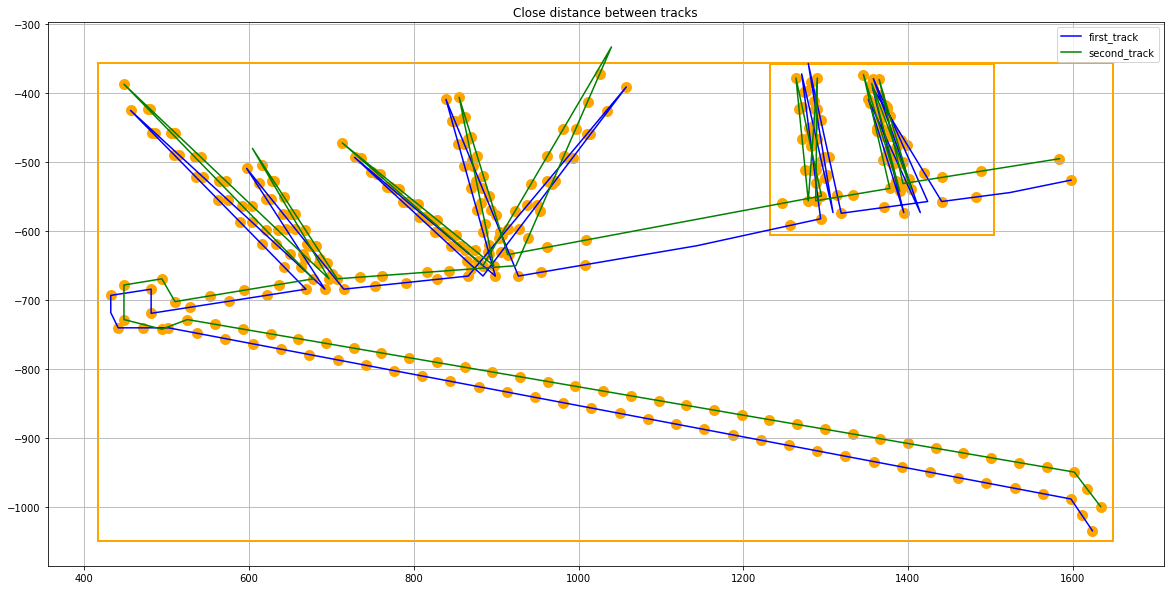

In [335]:
quality_distance_estimation_lscc(df_1, 
                                 df_3,
                                 show_far=False,
                                 show_medium=False,
                                 show_close=True,
                                 draw_points=True)

### The small deviation regions between 1-st and 2-rd tracks

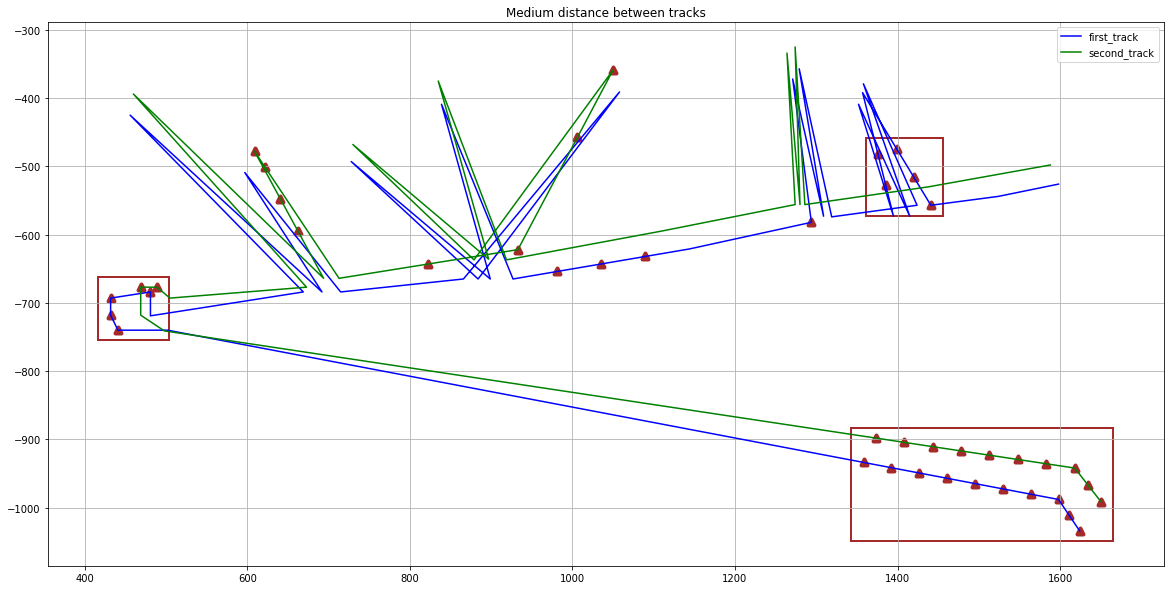

In [334]:
quality_distance_estimation_lscc(df_1, 
                                 df_2,
                                 show_far=False,
                                 show_medium=True,
                                 show_close=False,
                                 draw_points=True)

### The high deviation regions between 1-st and 4-rd tracks

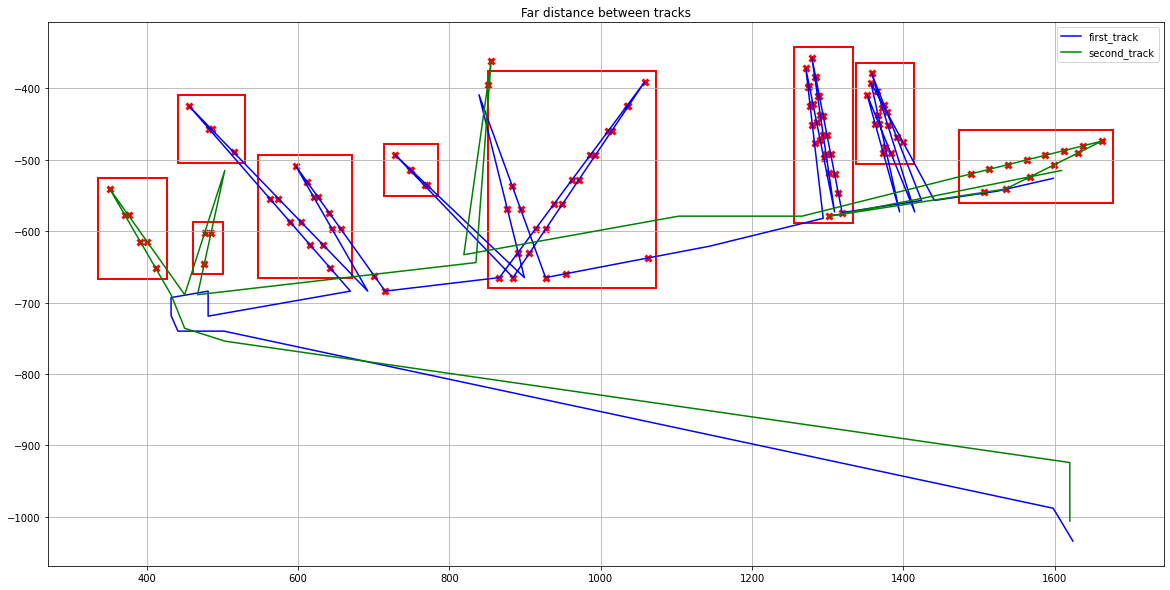

In [339]:
quality_distance_estimation_lscc(df_1, 
                                 df_4,
                                 show_far=True,
                                 show_medium=False,
                                 show_close=False,
                                 draw_points=True)

### The high deviation regions between 2-st and 4-rd tracks

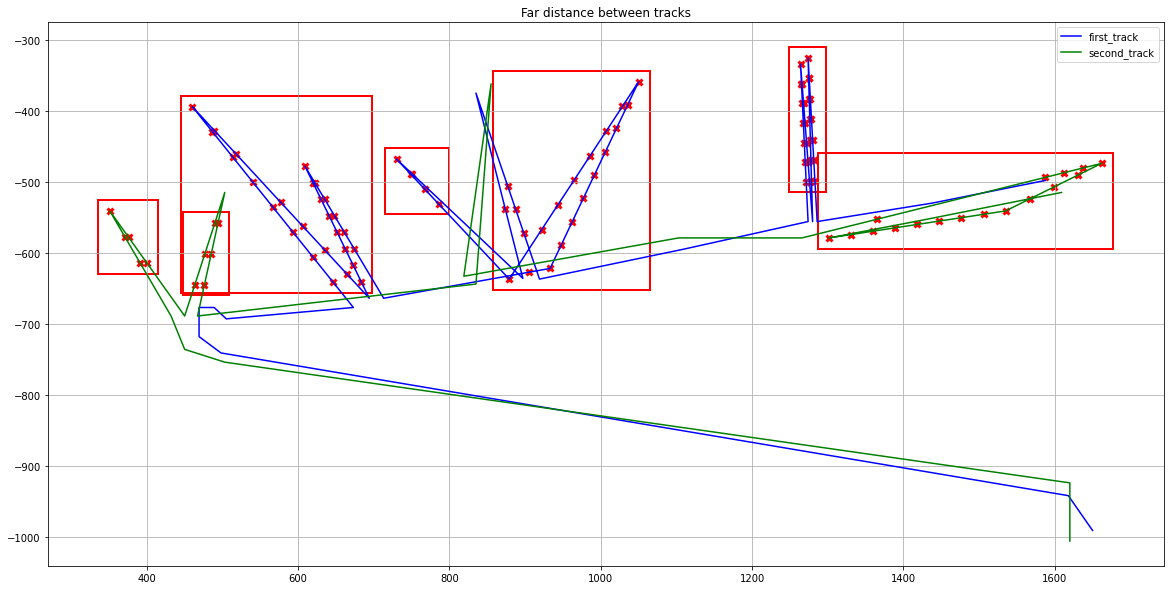

In [340]:
quality_distance_estimation_lscc(df_2, 
                                 df_4,
                                 show_far=True,
                                 show_medium=False,
                                 show_close=False,
                                 draw_points=True)

### The high deviation regions between 3-st and 4-rd tracks

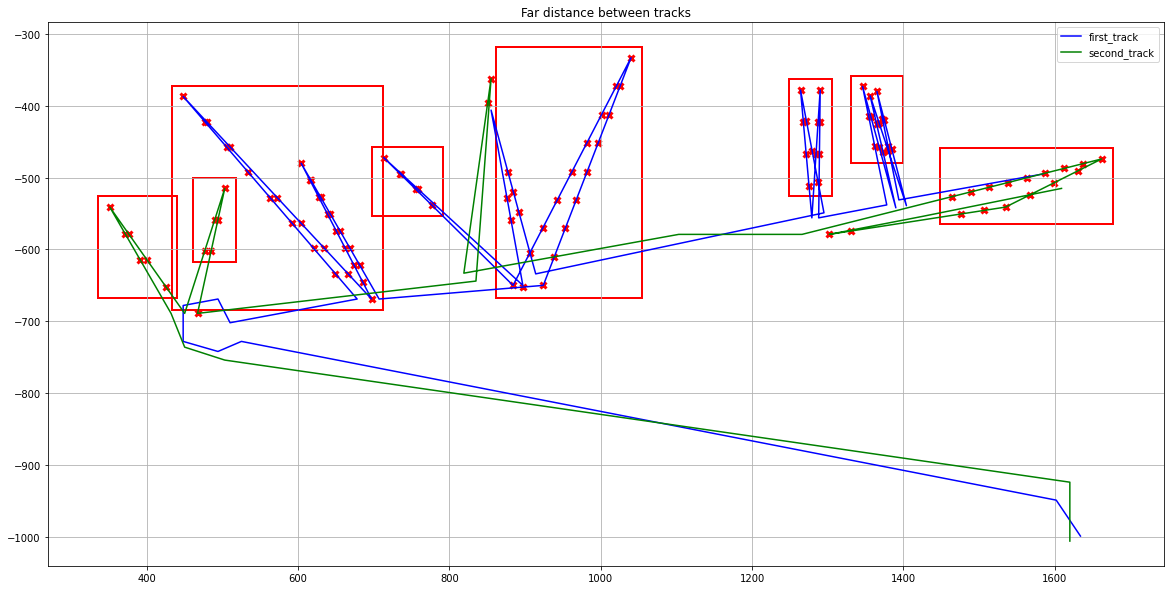

In [341]:
quality_distance_estimation_lscc(df_3, 
                                 df_4,
                                 show_far=True,
                                 show_medium=False,
                                 show_close=False,
                                 draw_points=True)